| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [4]:
library("dplyr", warn.conflicts = FALSE, quietly = TRUE)
library("ggplot2", warn.conflicts = FALSE, quietly = TRUE)
library("spatstat", warn.conflicts = FALSE, quietly = TRUE)
library("coda", warn.conflicts = FALSE, quietly = TRUE)

# Exercise 1

Given the following un-normalized posterior distribution:

$
g(\theta ∣ x) \propto \frac{1}{2} \exp{\left(-\frac{(\theta + 3)^2}{2}\right)} + \frac{1}{2} \exp{\left(-\frac{(\theta - 3)^2}{2}\right)}
$

- Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
- Use a Norm (0, 1) as random-walk candidate density
- Plot the sampled distribution
- Analyze the chain with the CODA package and plot the chain autocorrelation
- Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters? 

In [55]:
post_distr <- function(theta) {
  return(1 / 2 * (exp(- (theta + 3) ^ 2 / 2) + exp(- (theta - 3) ^ 2 / 2)))
}

metropolis_step <- function(theta) {
  proposed_theta <- rnorm(1, theta, 1)
  prob_r <- dnorm(theta, proposed_theta, 1) / dnorm(proposed_theta, theta, 1)
  accept_prob <- min(1, prob_r * post_distr(proposed_theta) / post_distr(theta))
  u <- runif(1)

  if (u <= accept_prob) {
    value <- proposed_theta
    accepted <- TRUE
  } else {
    value <- theta
    accepted <- FALSE
  }

  out <- data.frame(value = value, accepted = accepted)
  out
}

metropolis_sampler <- function(initial_theta, n, burn_in = 0) {
  results <- list()
  current_theta <- initial_theta

  for (i in 1:burn_in) {
    out <- metropolis_step(current_theta)
    current_theta <- out$value
  }

  for (i in 1:n) {
    out <- metropolis_step(current_theta)
    current_theta <- out$value
    results[[i]] <- out
  }

  results <- do.call(rbind, results)
  results
}

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


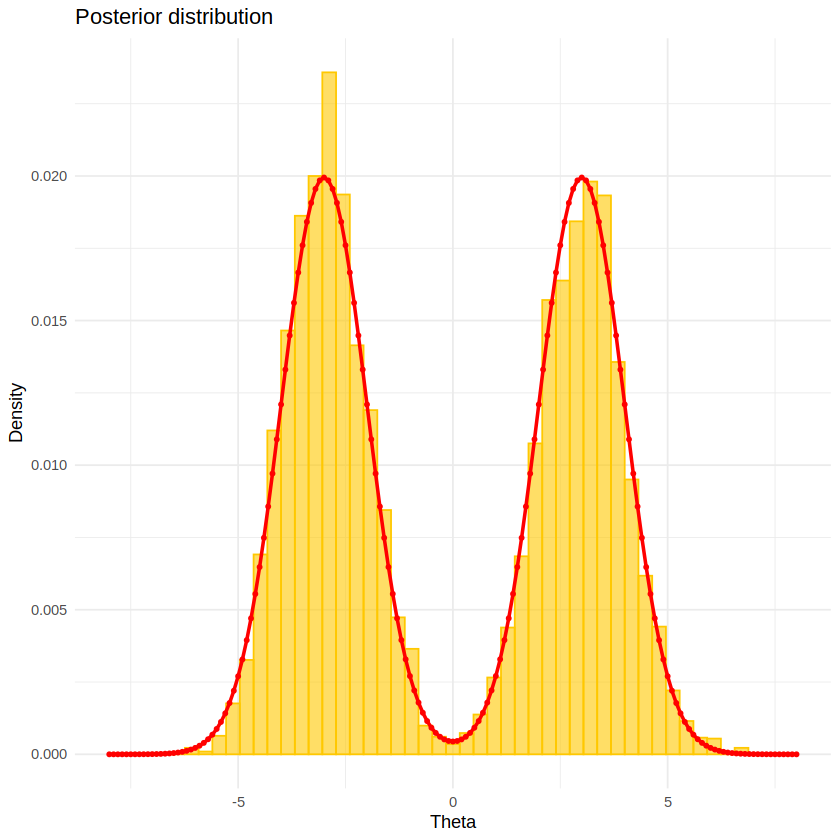

In [58]:
theta_values <- seq(-8, 8, 0.1)
post_values <- post_distr(theta_values) / sum(post_distr(theta_values))

random_theta <- rnorm(1, 0, 1)
n_sample <- 10000
out <- metropolis_sampler(random_theta, n_sample)

n_bins <- 50
bin_w <- (max(theta_values) - min(theta_values)) / n_bins

ggplot(data = data.frame(out$value), aes(x = out$value)) +
  geom_histogram(aes(y = after_stat(count / sum(count)) * bin_w),
                 color = "#ffc800", fill = "#ffc800", binwidth = bin_w,
                 bins = n_bins, alpha = 0.6) +
  geom_point(data = data.frame(theta_values, post_values),
             aes(x = theta_values, y = post_values), color = "red", size = 1) +
  geom_line(data = data.frame(theta_values, post_values),
            aes(x = theta_values, y = post_values), color = "red",
            linewidth = 1) +
  labs(title = "Posterior distribution",
       x = "Theta",
       y = "Density") +
  xlim(min(theta_values), max(theta_values)) +
  theme_minimal()

Effective size: 39.37588

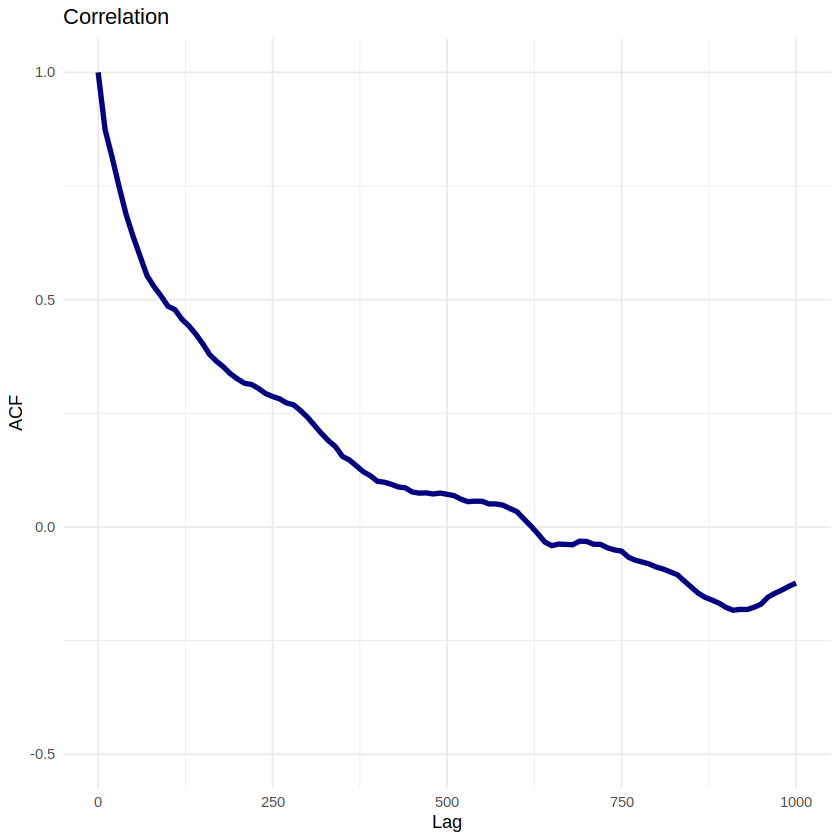

In [60]:
chain_1 <- as.mcmc(out$value)
lags <- seq(0, 1000, 10)
ACF <- autocorr(chain_1, lags = lags) # nolinter

ggplot(data = data.frame(lags, ACF), aes(x = lags, y = ACF)) +
  geom_line(color = "navy", linewidth = 1.5) +
  labs(title = "Correlation",
       x = "Lag",
       y = "ACF") +
  ylim(-0.5, 1) +
  theme_minimal()

cat("Effective size:", effectiveSize(chain_1))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


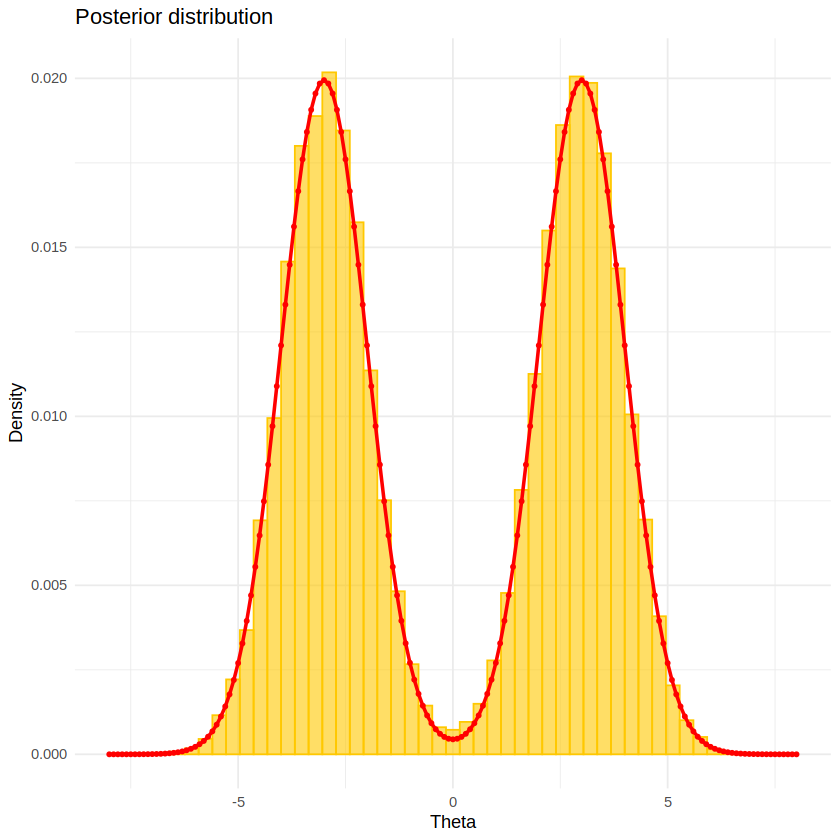

Effective size: 361.0119

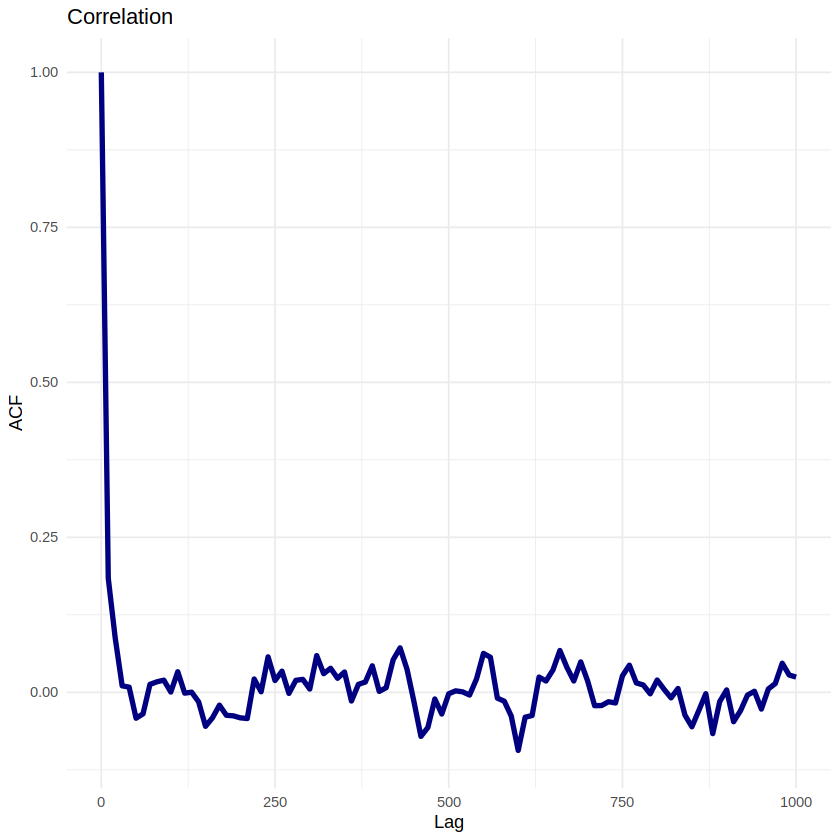

In [47]:
theta_values <- seq(-8, 8, 0.1)
post_values <- post_distr(theta_values) / sum(post_distr(theta_values))

random_theta <- rnorm(1, 0, 1)
n_sample <- 10000
out <- metropolis_sampler(random_theta, theta_values, n_sample)
accepted_values <- out$value[out$accepted == TRUE]

n_bins <- 50
bin_w <- (max(theta_values) - min(theta_values)) / n_bins

ggplot(data = data.frame(accepted_values), aes(x = accepted_values)) +
  geom_histogram(aes(y = after_stat(count / sum(count)) * bin_w),
                 color = "#ffc800", fill = "#ffc800", binwidth = bin_w,
                 bins = n_bins, alpha = 0.6) +
  geom_point(data = data.frame(theta_values, post_values),
             aes(x = theta_values, y = post_values), color = "red", size = 1) +
  geom_line(data = data.frame(theta_values, post_values),
            aes(x = theta_values, y = post_values), color = "red",
            linewidth = 1) +
  labs(title = "Posterior distribution",
       x = "Theta",
       y = "Density") +
  xlim(min(theta_values), max(theta_values)) +
  theme_minimal()

thinning <- seq(1, to = nrow(out), by = 25) # thin by factor 25
thinned_out <- out[thinning, ]

chain_2 <- as.mcmc(thinned_out$value)
lags <- seq(0, 1000, 10)
ACF <- autocorr(chain_2, lags = lags) # nolinter

ggplot(data = data.frame(lags, ACF), aes(x = lags, y = ACF)) +
  geom_line(color = "navy", size = 1.5) +
  labs(title = "Correlation",
       x = "Lag",
       y = "ACF") +
  ylim(-0.1, 1) +
  theme_minimal()

cat("Effective size:", effectiveSize(chain_2))

Running with burn_in = 100 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


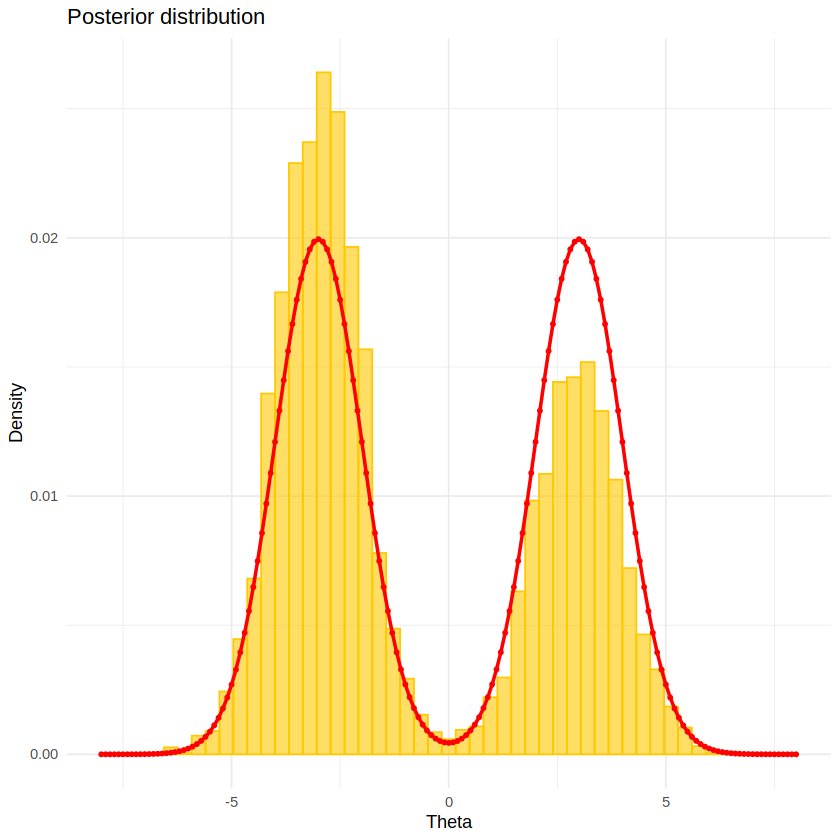

Effective size: 33.60462 
Running with burn_in = 100 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


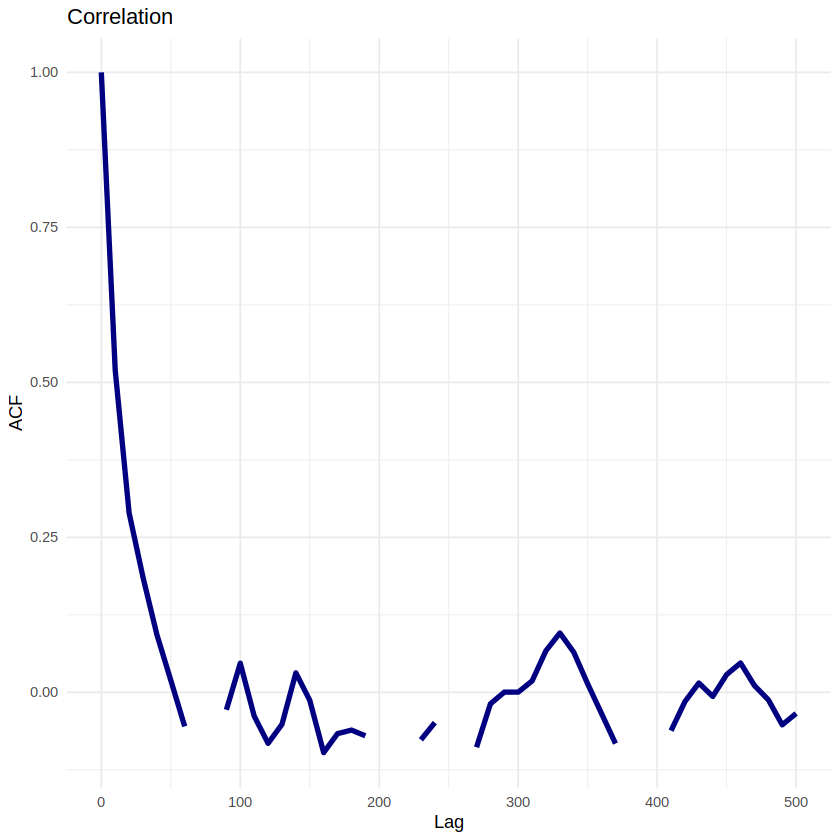

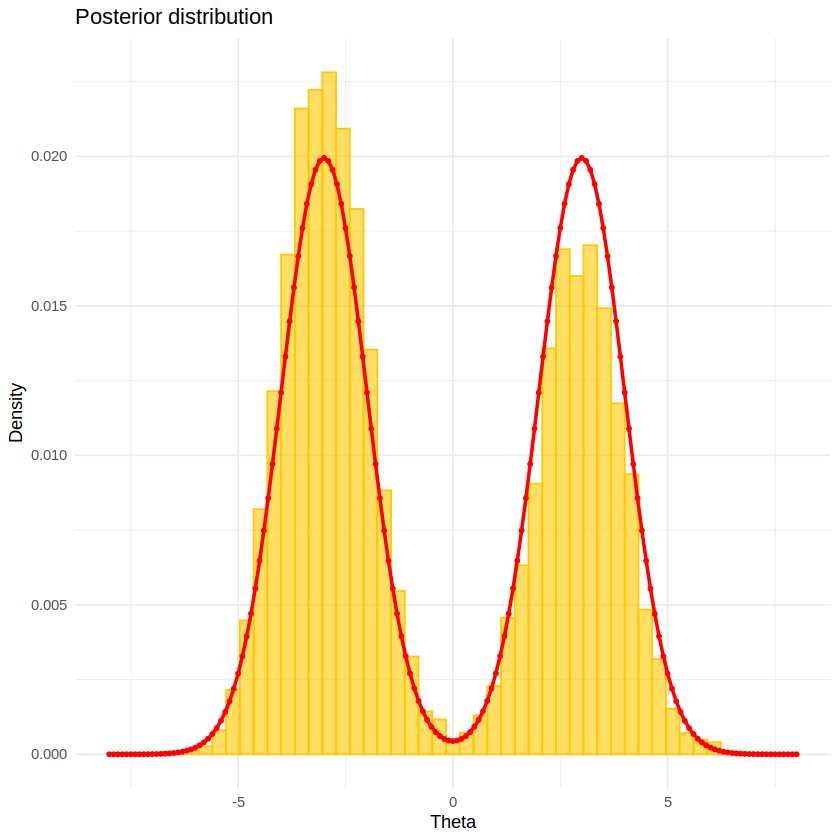

Effective size: 38.55941 
Running with burn_in = 100 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


ERROR: Error in data.frame(lags, ACF): arguments imply differing number of rows: 51, 50


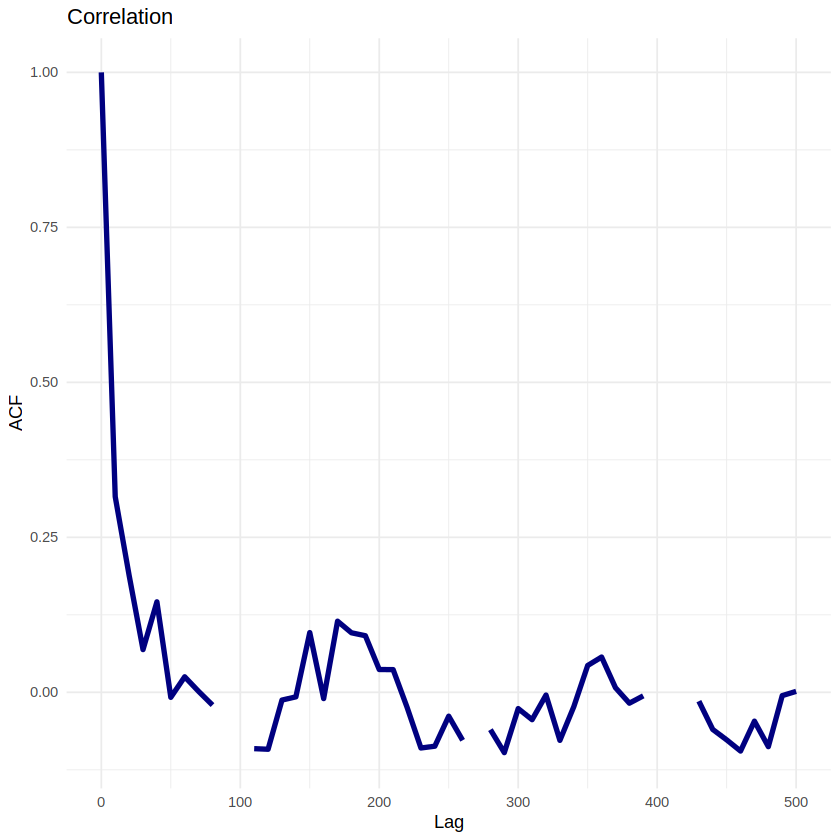

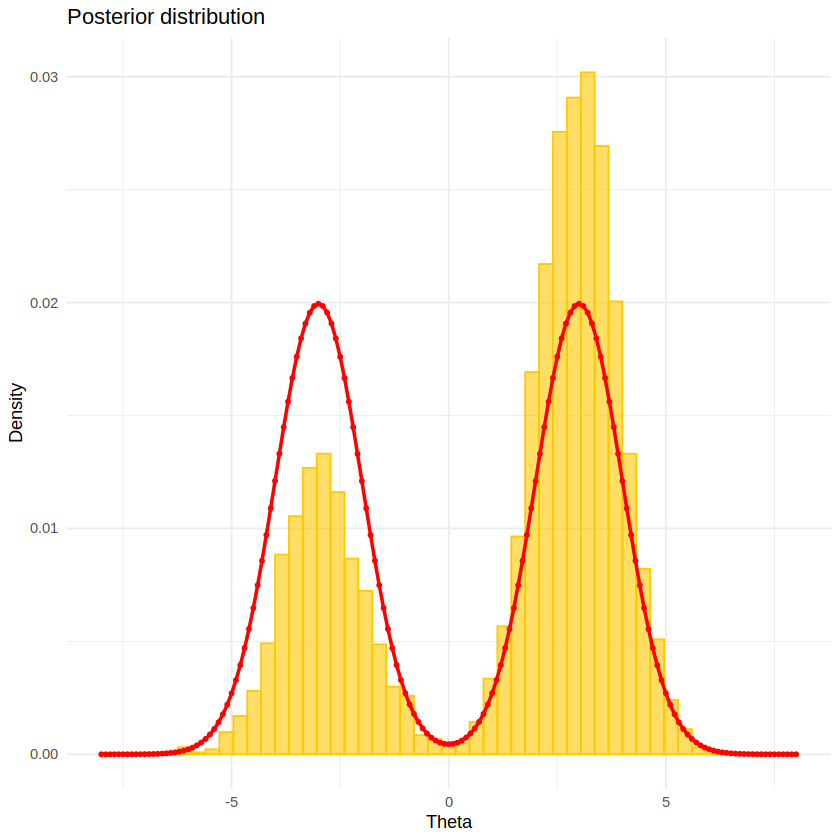

In [51]:
library(ggplot2)
library(coda)

# Define theta values and posterior distribution
theta_values <- seq(-8, 8, 0.1)
post_values <- post_distr(theta_values) / sum(post_distr(theta_values))

# Function to run Metropolis sampler
run_metropolis_sampler <- function(random_theta, theta_values, n_sample, burn_in) {
  out <- metropolis_sampler(random_theta, theta_values, n_sample, burn_in)
  accepted_values <- out$value[out$accepted == TRUE]
  return(list(out = out, accepted_values = accepted_values))
}

# Function to plot posterior distribution
plot_posterior_distribution <- function(accepted_values, theta_values, post_values, n_bins) {
  bin_w <- (max(theta_values) - min(theta_values)) / n_bins
  
  p <- ggplot(data = data.frame(accepted_values), aes(x = accepted_values)) +
    geom_histogram(aes(y = after_stat(count / sum(count)) * bin_w),
                   color = "#ffc800", fill = "#ffc800", binwidth = bin_w,
                   bins = n_bins, alpha = 0.6) +
    geom_point(data = data.frame(theta_values, post_values),
               aes(x = theta_values, y = post_values), color = "red", size = 1) +
    geom_line(data = data.frame(theta_values, post_values),
              aes(x = theta_values, y = post_values), color = "red",
              linewidth = 1) +
    labs(title = "Posterior distribution",
         x = "Theta",
         y = "Density") +
    xlim(min(theta_values), max(theta_values)) +
    theme_minimal()
  
  print(p)
}

# Function to plot ACF
plot_acf <- function(out, thinning) {
  thinned_out <- out[seq(1, nrow(out), by = thinning), ]
  chain_2 <- as.mcmc(thinned_out$value)
  lags <- seq(0, 500, 10)
  ACF <- autocorr(chain_2, lags = lags)
  
  p <- ggplot(data = data.frame(lags, ACF), aes(x = lags, y = ACF)) +
    geom_line(color = "navy", size = 1.5) +
    labs(title = "Correlation",
         x = "Lag",
         y = "ACF") +
    ylim(-0.1, 1) +
    theme_minimal()
  
  print(p)
  
  cat("Effective size:", effectiveSize(chain_2), "\n")
}

# Define parameters
burn_in_values <- c(100, 500, 1000)
thinning_values <- c(10, 15, 20)
random_theta <- rnorm(1, 0, 1)
n_sample <- 10000
n_bins <- 50

# Run simulations for different burn_in and thinning values
for (burn_in in burn_in_values) {
  for (thinning in thinning_values) {
    cat("Running with burn_in =", burn_in, "and thinning =", thinning, "\n")
    
    # Run Metropolis sampler
    result <- run_metropolis_sampler(random_theta, theta_values, n_sample, burn_in)
    
    # Plot posterior distribution
    plot_posterior_distribution(result$accepted_values, theta_values, post_values, n_bins)
    
    # Plot ACF
    plot_acf(result$out, thinning)
  }
}
